# **머신러닝 시스템 설계하기**

얼굴인식 문제에 대하여 특징추출 및 분류기 구현을 통해 간단한 머신러닝 시스템을 개발해 본다.

**구글 드라이브 마운트**

먼저, 구글 드라이브에 feret_trim.csv를 업로드하고, 이를 사용하기 위해 구글 드라이브를 마운트한다.

In [1]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


**데이터 로드**

FERET 데이터를 로드하고 학습 데이터와 테스트 데이터 및 레이블을 할당한다.

로드된 데이터는 450x2001차원을 가지며, 마지막 열에 해당하는 값이 클래스 라벨이다.

(450, 2001) 

x_train (150, 2000) 

y_train (150,) 

x_test (300, 2000) 

y_test (300,) 



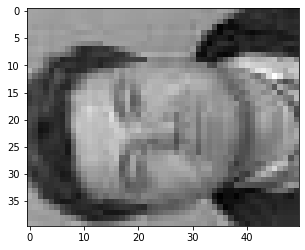

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.read_csv('/content/gdrive/My Drive/MyColab/Data/feret_trim.csv',header=None)
feret_file = np.array(df)
print(feret_file.shape, '\n')  # 450x2001 차원

# 학습, 테스트 데이터 할당
x_train = feret_file[0:150, 0:2000]
y_train = feret_file[0:150, 2000]
x_test = feret_file[150:450, 0:2000]
y_test = feret_file[150:450, 2000]
print('x_train', x_train.shape, '\n')
print('y_train', y_train.shape, '\n')
print('x_test', x_test.shape, '\n')
print('y_test', y_test.shape, '\n')


# 2000차원 벡터를 reshape하여 얼굴 이미지 시각화 해 보기
temp_showimg = x_train[0, :]
plt.imshow(x_train[0, :].reshape(40, 50),cmap=plt.cm.gray)

데이터를 reshape하여 시각화했더니 얼굴이 왼쪽으로 90도 틀어져 보인다.

이러한 경우 아래 코드를 통해 이미지를 회전하여 시각화 할 수 있다.

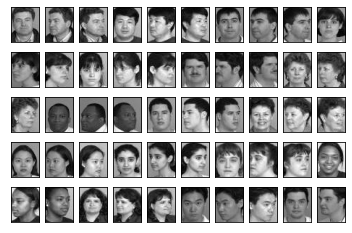

In [3]:
# reshape한 50개의 학습 데이터를 회전시켜 시각화
for i, comp in enumerate(x_train[:50]):
  # reshape에서 -1을 인자로 줄 경우 뒤 차원 수는 앞 차원에 맞추어 자동으로 할당됨
  reshaped_image = comp.reshape(40, -1) 
  rotated_image = np.rot90(reshaped_image, 3)   # 시계 반대 방향으로 90도씩 3번 회전
  plt.subplot(5, 10, i + 1)
  plt.imshow(rotated_image, cmap=plt.cm.gray)
  plt.xticks(())
  plt.yticks(())

#print(x_train[0, :])
#plt.imshow(x_train[0, :].reshape(40, 50),cmap=plt.cm.gray)

**데이터 전처리 - PCA**

주성분분석을 통해 차원 축소 및 특징추출을 한다.

먼저, 정보손실이 5% 미만 되는 주성분의 개수를 알아보고, 구해진 주성분의 개수로 학습 및 테스트 데이터를 차원 축소한다.

In [8]:
# PCA
from sklearn.decomposition import PCA

n_components = 150
pca = PCA(n_components = n_components)
pca.fit_transform(x_train)

# attributes 확인하기
comp_rat = pca.explained_variance_ratio_  # 주성분이 포괄하는 데이터의 비율
#print(comp_rat) 
print('평균 : ', pca.mean_, pca.mean_.shape)


sum_cr = 0
m = 0
for cr in comp_rat:
    sum_cr = sum_cr + cr
    m = m + 1
    if sum_cr > 0.95:
        break

print('정보 보존율 :', sum_cr)  # 정보 보존율
print('m =', m)
print('\n')

# PCA에 의한 학습 및 테스트 데이터 차원 축소
pca_m = PCA(n_components = m)
pca_m.fit(x_train)
z_pca_train = pca_m.transform(x_train)
z_pca_test = pca_m.transform(x_test)
print(z_pca_train.shape)
print(z_pca_train)
print(z_pca_test.shape)
print(z_pca_test)

평균 :  [0.51372549 0.50993464 0.50457516 ... 0.36394771 0.37108497 0.37882353] (2000,)
정보 보존율 : 0.9511884839734255
m = 69


(150, 69)
[[ 0.30875442 -0.74369699  1.41603089 ...  0.01634818 -0.33328854
   0.18168627]
 [ 0.61470255  3.01796721  1.76872521 ...  0.02432314  0.27233651
  -0.2696441 ]
 [-1.10234803 -2.4221141  -1.19491754 ...  0.22975575  0.17743549
   0.0919387 ]
 ...
 [ 1.93780195  0.28405185 -2.65950005 ...  0.32385976  0.10535211
  -0.35767538]
 [ 1.82709503  3.34631818 -2.21319341 ... -0.32925362 -0.22135587
   0.27049579]
 [ 2.20701556 -1.10744653 -2.2495514  ...  0.32237212  0.33128769
   0.41097106]]
(300, 69)
[[ 3.63776172e-01  2.00042438e+00  1.38982651e+00 ...  5.06443721e-03
   1.23029276e-01 -3.02641484e-01]
 [ 1.16288942e-01  1.10203777e+00  1.35627127e+00 ... -1.74824697e-01
  -1.24756940e-01 -2.54558667e-01]
 [-1.20708789e-01  6.70008477e-01  1.34383673e+00 ...  1.80716751e-01
   2.53162806e-01 -1.91587067e-01]
 ...
 [ 2.32469725e+00  4.02409436e-01 -2.19588017

**데이터 전처리 - LDA**

PCA를 통해 차원 축소된 특징값을 입력 벡터로 사용하여 선형판별분석을 수행한다.

In [9]:
# LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(z_pca_train, y_train)
z_lda_train = lda.transform(z_pca_train)
z_lda_test = lda.transform(z_pca_test)
print(z_lda_train.shape)
print(z_lda_train)
print(z_lda_test.shape)
print(z_lda_test)

(150, 49)
[[-2.78795258  3.61101792  5.1416274  ... -0.07431997 -0.51604318
  -0.12782916]
 [-1.81262843  1.87892859  4.7686412  ... -0.63175087 -0.50340903
  -0.20877262]
 [-2.22870124  2.57043289  7.16689209 ...  0.5113953   0.84439108
   0.26795167]
 ...
 [ 4.35660882 -5.91433206 -1.33339751 ... -0.57475891  0.58655285
   0.10081099]
 [ 3.85137936 -5.35191207 -1.23929349 ...  2.11507183 -1.12565197
   0.56282785]
 [ 5.57281967 -5.56440848 -1.88854102 ... -0.68898949  0.45172834
  -0.44120129]]
(300, 49)
[[-2.31003476e+00  6.57314217e-01  2.78733105e+00 ...  7.77155731e-04
   8.44408999e-01 -5.63306391e-01]
 [-2.38018325e+00  3.13851659e-01  3.52835763e+00 ... -2.75368770e-01
   4.84773607e-01 -7.42975440e-01]
 [-2.10973653e+00  2.81624213e+00  3.39170426e+00 ... -2.31510715e-01
   6.96941554e-01 -7.95356598e-01]
 ...
 [ 4.26752253e+00 -6.91994606e+00 -6.16178630e+00 ...  3.68007229e-01
   1.00651443e+00  9.09844209e-01]
 [ 4.37162173e+00 -6.82589363e+00 -4.55263933e+00 ...  1.172747

**K-최근접이웃 분류기를 통한 성능 측정**

K = 1인 경우의 최근접이웃분류기를 통하여 원래 데이터, PCA로 추출된 특징값,

그리고 PCA를 거쳐 LDA로 추출된 특징값을 사용하여 분류율을 측정한다.

In [14]:
from scipy.spatial import distance
from sklearn.neighbors import  KNeighborsClassifier

K = 1
neigh = KNeighborsClassifier(n_neighbors = K)
neigh.fit(x_train, y_train)
y_KNN = neigh.predict(x_test)
print('Classification error of 1-NN using Raw Data:',np.sum(np.abs(y_KNN - y_test)>0)/y_test.shape[0])

neigh.fit(z_pca_train, y_train)
y_pca_KNN = neigh.predict(z_pca_test)
print('Classification error of 1-NN using PCA features:',np.sum(np.abs(y_pca_KNN - y_test)>0)/y_test.shape[0])

neigh.fit(z_lda_train, y_train)
y_lda_KNN = neigh.predict(z_lda_test)
print('Classification error of 1-NN using LDA features:',np.sum(np.abs(y_lda_KNN - y_test)>0)/y_test.shape[0])

Classification error of 1-NN using Raw Data: 0.13666666666666666
Classification error of 1-NN using PCA features: 0.13
Classification error of 1-NN using LDA features: 0.09


**특징 차원에 따른 분류율 변화**

PCA와 LDA를 통해 얻은 특징의 차원에 따른 분류율의 변화를 살펴본다.

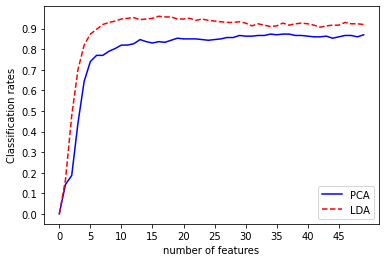

In [15]:
# 최대 특징추출 차원 수는 (클래스 수 - 1)개까지 설정
max_feature_dim = len(np.unique(y_train)) - 1

# 분류율 저장 변수
acclist_pca = []
acclist_lda = []
acclist_pca.append(0)
acclist_lda.append(0)


# 분류율 변화 계산
i = 0
while(i < max_feature_dim):
    i = i + 1

    # PCA 특징추출
    z_pca = PCA(n_components = i)
    z_pca.fit_transform(x_train)
    z_pca_train = z_pca.transform(x_train)
    z_pca_test = z_pca.transform(x_test)

    # LDA 특징추출
    z_lda = LinearDiscriminantAnalysis(n_components = i)
    z_lda.fit(x_train, y_train)
    z_lda_train = z_lda.transform(x_train)
    z_lda_test = z_lda.transform(x_test)

    # PCA features의 1-NN 분류
    PCA_neigh = KNeighborsClassifier(n_neighbors = K)
    PCA_neigh.fit(z_pca_train, y_train)
    y_pca_KNN = PCA_neigh.predict(z_pca_test)
    acc_pca = 1 - (np.sum(np.abs(y_pca_KNN - y_test)>0)/y_test.shape[0])
    acclist_pca.append(acc_pca)
    # LDA features의 1-NN 분류
    LDA_neigh = KNeighborsClassifier(n_neighbors = K)
    LDA_neigh.fit(z_lda_train, y_train)
    y_lda_KNN = LDA_neigh.predict(z_lda_test)
    acc_lda = 1 - (np.sum(np.abs(y_lda_KNN - y_test)>0)/y_test.shape[0])
    acclist_lda.append(acc_lda)


# 그래프 그리기
plt.xlabel("number of features")
plt.ylabel("Classification rates")
plt.xticks(np.arange(0, 50, 5)) # x축 범위 지정 plt.xlim([0, 50])
plt.yticks(np.arange(0, 1, 0.1)) # y축 범위 지정 plt.ylim([0, 1])
plt.plot(np.unique(y_train) - 1, acclist_pca, 'b-', label='PCA')
plt.plot(np.unique(y_train) - 1, acclist_lda, 'r--', label='LDA')
plt.legend()
plt.show()
